<a href="https://colab.research.google.com/github/sindhurvcgit123/credit_Risk_Project/blob/main/credit_risk_interpretability.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Logistic Regression Performance:
              precision    recall  f1-score   support

           0       0.84      0.80      0.82        88
           1       0.89      0.92      0.91       162

    accuracy                           0.88       250
   macro avg       0.87      0.86      0.86       250
weighted avg       0.88      0.88      0.88       250

XGBoost Performance:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99        88
           1       0.99      1.00      1.00       162

    accuracy                           1.00       250
   macro avg       1.00      0.99      1.00       250
weighted avg       1.00      1.00      1.00       250



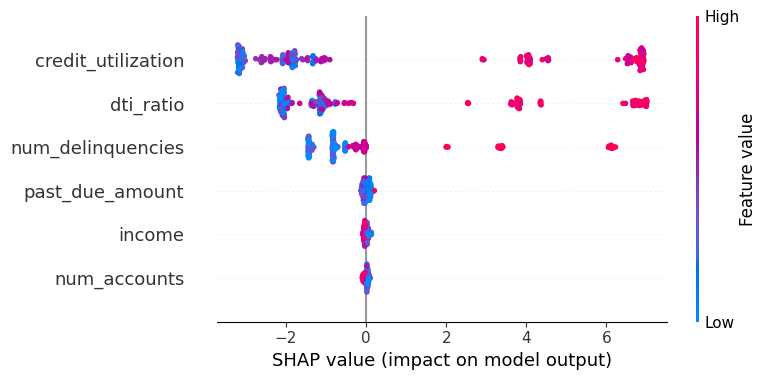

In [5]:
!pip install lime
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from xgboost import XGBClassifier # Corrected import statement

import shap
from lime.lime_tabular import LimeTabularExplainer
import matplotlib.pyplot as plt

# Load dataset
df = pd.read_csv("credit_data.csv")
df = df.dropna()

X = df.drop("default", axis=1)
y = df["default"]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.25, random_state=42
)

# Logistic Regression
log_model = LogisticRegression(max_iter=2000)
log_model.fit(X_train, y_train)
y_pred_log = log_model.predict(X_test)
print("Logistic Regression Performance:")
print(classification_report(y_test, y_pred_log))

# XGBoost
xgb = XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.9,
    colsample_bytree=0.9,
    random_state=42
)
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)
print("XGBoost Performance:")
print(classification_report(y_test, y_pred_xgb))

# SHAP
explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, feature_names=X.columns)

# Logistic coefficients
coef_df = pd.DataFrame({
    'Feature': X.columns,
    'Logistic_Coefficient': log_model.coef_[0]
}).sort_values(by='Logistic_Coefficient', ascending=False)
coef_df

# LIME
X_test_array = np.array(X_test)
explainer_lime = LimeTabularExplainer(
    training_data=X_train,
    feature_names=X.columns,
    class_names=['Not Default', 'Default'],
    mode='classification'
)

case_ids = [10, 25, 40]
for case in case_ids:
    exp = explainer_lime.explain_instance(
        X_test_array[case],
        xgb.predict_proba
    )
    exp.save_to_file(f"lime_case_{case}.html")